# 시작하기 전에

### 이번 차시의 목표

1. 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근에 대해 알기

#### 1) 얼굴의 특징점?

   - 얼굴의 특징을 이루는 눈, 코, 입, 귀를 찾아내는 기술 __랜드마크(조정 alignment)__
   - 확장되면 "키포인트 디텍션(Keypoint Detection" 
   
#### 2) 카메라 스티커 앱을 만드는 순서
   - 1. 얼굴이 있는 사진을 준비
   - 2. 얼굴의 바운딩 박스를 찾아내기
   - 3. 바운딩 박스 안에서 얼굴 영역(Face Landmark)을 찾아내기
   - 3. 얼굴 영역에 스티커 붙이기!

#### 3) 이미지를 읽어오고 저장하기

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
print("임포트 완료!")

임포트 완료!


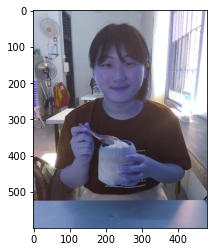

In [12]:
image_path = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex3_CameraSticker/Images/malaka.JPG'

img_brg = cv2.imread(image_path)
img_brg = cv2.resize(img_brg, (480,600))
img_show = img_brg.copy()

plt.imshow(img_brg)
plt.show()

   - 왜 얼굴이 파란색이야 ㅠㅠㅠ
   > matplotlib, dlib 등의 이미지 라이브러리는 이미지 채널을 RGB로 사용하지만, 
   > openCV는 BGR을 사용한다.

#### 이번 기회에, openCV에 대해 좀 더 알아보자.

   - 사용한 함수 cv2.imread(파일, 옵션) 
   - 옵션 1은 컬러, 0은 그레이스케일, -1은 알파까지 포함한 값을 의미한다.

## 2) 어떻게 얼굴 검출을 할까? -> Face Detection

   - 1) dlib의 face detector을 활용하기로 하자.
       : face detector는 HOG(Histogram of Oriented Gradient) feature 을 사용하여    
       SVM의 슬라이딩 윈도우로 얼굴을 찾는다.
       
   ![딥러닝을 사용한 얼굴 인식](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)   
   
   > HOG 방식이 동작하는 방법
   > 1. 이미지에서 얼굴을 검출하기 위해 모든 픽셀을 흑백으로 만든다.
   > 2. 각각의 픽셀이 주변을 둘러싼 픽셀과 비교하여 얼마나 어두운지 알아내야 한다. (이미지의 빛방향 검출)
   > 3. 빛방향을 알아내 화살표를 그리고, 이 방향을 고려하면 같은 인물에 대해서는 빛의 밝기와 상관없이
   > 4. 항상 같은 결과를 알게 된다!!
   
   > 그리고 얼굴 교정(Posing)과 투영(Projection) __얼굴 각도가 다르면 어떻게 알아?__
   > face landmark estimation 이라는 알고리즘을 써서 이를 교정!
   > __얼굴에 존재하는 68개의 랜드마크를 찾아내는 것__
   > 얼굴에 대한 평행선을 보존하는 회전, 크기 조절을 통해 눈코입을 기준으로 랜드마크를 찾음
   
   > 그럼 __전혀 다른 사진들을 볼 때 어떻게 '그 특정 인물을 찾아내지?'__
   > 딥 컨볼루션 신경망을 훈련시켜 각 얼굴에 대한 128개의 측정값을 생성하도록 함.
   > 나의 사진 1 ======== 나의 사진 2 <==========> 다른 사람 사진
   > 이 때 생기는 __'각 얼굴에 대한 128개의 측정값' == 임베딩__
   
   > 이제 이 사람의 이름을 붙여주자!
   > SVM 분류기를 통해 이름을 찾아내고, 분류해 줌.

### 2-1. dlib 를 활용한 hog detector 선언

In [16]:
import dlib

hog_detector = dlib.get_frontal_face_detector()
print("Hog detector 선언 완료!")

Hog detector 선언 완료!


#### 2-2. 바운딩 박스로 얼굴 검출 후 출력해보기

In [21]:
#바운딩 박스로 얼굴 검출!
img_rgb = cv2.cvtColor(img_brg, cv2.COLOR_BGR2RGB)
dlib_rects = hog_detector(img_rgb, 1)

# 찾은 얼굴의 좌표를 알려줌
print("얼굴 검출 완료!")
print(dlib_rects) 

얼굴 검출 완료!
rectangles[[(167, 125) (296, 254)]]


   > * 이미지 피라미드?   
   > 이미지 upsampling을 통해 크기를 키우는 것    
   > 동일한 사진을, 다양한 사이즈로 축소하면서 set을 만들어감.     
   > 사진에서 얼굴을 검출할 때, '이 사진에서 얼굴이 어떤 크기일 지 모르기 때문에' 이에 대비하기 위해    
   > 다양한 사이즈의 얼굴을 미리 생성하여 얼굴 검출에 도움이 되도록 함.

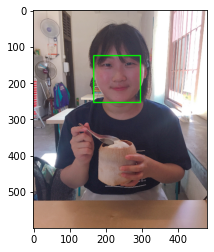

In [22]:
for dlib_rect in dlib_rects :
    l = dlib_rect.left()
    r = dlib_rect.right()
    t = dlib_rect.top()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 내 얼굴에서 특징을 찾아라! 랜드마크 ~건설~

### 3-1. Object keypoint estimation 알고리즘

   - 객체 내부의 점을 찾는 기술을 object keypoint estimation 알고리즘이라고 하고, 이는 2가지가 있다.
   - 1) 탑-다운 방식 : 바운딩 박스를 찾고, 박스 내부의 키포인트를 예측
   - 2) 바텀-업 방식 : 이미지 전체의 키포인트를 먼저 찾고, 포인트의 관계를 이용해 박스를 검출
   
  > ** 우리는 68개의 얼굴 포인트를 찾을거라구 ** 
  > ![Regression Tree를 활용한 앙상블 기법으로 얼굴 Alignment](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)

### 3-2. Dlib에서 제공하는 라이브러리를 통해 landmark 검출

 * 먼저, 라이브러리를 다운받고 모델의 압축을 풀어줌.
 

In [24]:
import os
model_path = os.getenv('HOME') + '/SUBMIT_MISSION_GIT/ex3_CameraSticker/Models'

landmark_detector = dlib.shape_predictor(model_path + '/shape_predictor_68_face_landmarks.dat')
print("모델을 무사히 데려왔습니다!")

모델을 무사히 데려왔습니다!


In [27]:
# landmark_detector는 RGB, dlib.rectangle을 인자로
# 디텍션한 포인트들을 반환한다.

list_landmarks = []

for dlib_rect in dlib_rects :
    points=landmark_detector(img_rgb, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
  
#가져온 랜드마크의 개수가 정말 68개인지 확인해보자
print(len(list_landmarks[0]))

68


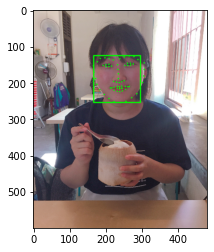

In [28]:
# 리스트에 넣은 랜드마크들을 사진 위에 찍어 표시해보자

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0,255,0), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

__무서울 정도로 포인트를 잘 잡고 있다 ^^...__